In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.integrate import odeint, solve_ivp

from dataset import Dataset
import NeuralNet 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
d = Dataset()
d.get_data(exp=1)

# Solve for 0.6794, 0.0002, 0.2572 kinetic parameter values
sol = d.solve_ode(mu_max=0.6794, Km=0.0002, Y_XS=0.2572)
# d.plot_solution(sol)
train_df = d.training_dataset(N=5000)
print(f'Train data shape: {train_df.shape}')

100%|██████████| 5000/5000 [00:12<00:00, 385.43it/s]

Train data shape: (4908, 19)


Epoch: 0, Loss: 0.20619836449623108, Val Loss: 0.075221948325634
Epoch: 500, Loss: 0.026251576840877533, Val Loss: 0.02755250781774521
Epoch: 1000, Loss: 0.022445037961006165, Val Loss: 0.024041326716542244
Epoch: 1500, Loss: 0.021187590435147285, Val Loss: 0.022711211815476418
Epoch: 2000, Loss: 0.033453319221735, Val Loss: 0.05169229209423065
Epoch: 2500, Loss: 0.019580336287617683, Val Loss: 0.02102448232471943
Epoch: 3000, Loss: 0.018814798444509506, Val Loss: 0.020207105204463005
Epoch: 3500, Loss: 0.018224669620394707, Val Loss: 0.019539320841431618
Epoch: 4000, Loss: 0.01807650551199913, Val Loss: 0.019412174820899963
Epoch: 4500, Loss: 0.01794874668121338, Val Loss: 0.019560681656003


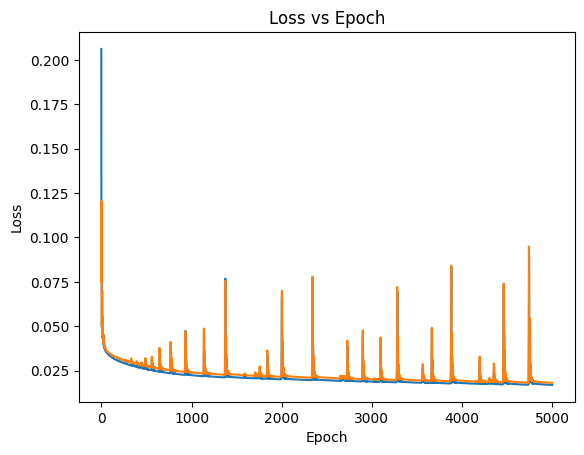

In [7]:
X, y = NeuralNet.preprocess_data(train_df)
net = NeuralNet.NN()
X_train, y_train, X_val, y_val = net.train_val_split(X, y)

losses_train = []
losses_val = []
for i in range(5000):
    loss_train, loss_val = net.train(X_train, y_train, X_val, y_val)    
    losses_train.append(loss_train)
    losses_val.append(loss_val)
    if i % 500 == 0:
        print(f'Epoch: {i}, Loss: {loss_train}, Val Loss: {loss_val}')
                
plt.plot(losses_train, label='Train')
plt.plot(losses_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

In [8]:
# Evaluate on df experimental data
X_test = d.df['Biomass'].values
S_test = d.df['Glucose'].values

X_test = torch.tensor(X_test, dtype=torch.float32)
S_test = torch.tensor(S_test, dtype=torch.float32)

test_df = torch.hstack((X_test, S_test)).view(1,-1)

# Predict
mu_max, Km, Y_XS = net.predict(test_df).detach().numpy().flatten()
print(f'Predicted mu_max: {mu_max}, Km: {Km}, Y_XS: {Y_XS}')

Predicted mu_max: 0.8333432674407959, Km: 0.002867467701435089, Y_XS: 0.4197619557380676


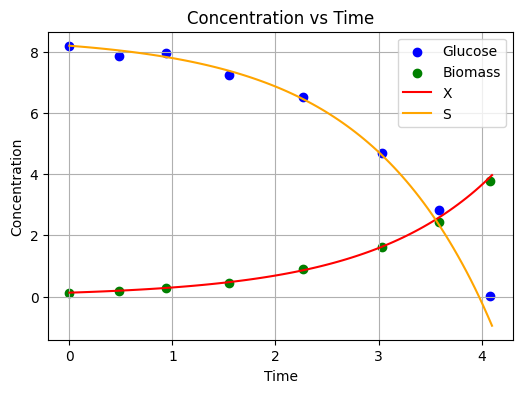

In [9]:
sol = d.solve_ode(mu_max=mu_max, Km=Km, Y_XS=Y_XS)
d.plot_solution(sol)

## PINN

In [44]:
from PINN import PINN, get_loss

%load_ext autoreload
%autoreload 2

pinn = PINN(1, 2)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
criterion = nn.MSELoss()

t_train = d.df['Time'].values
u_train = d.df[['Biomass', 'Glucose']].values

# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().view(-1,1)
us_train = torch.tensor(u_train, requires_grad=True).float()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
EPOCHS = 10000
LOSS = []
for epoch in range(EPOCHS):
    u_pred = pinn(ts_train)
    residual_pred = get_loss(pinn)
    loss = criterion(u_pred, us_train)
    loss += torch.mean(residual_pred)
    
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.7000701427459717
Epoch: 500, Loss: 0.2698264420032501
Epoch: 1000, Loss: 0.17278626561164856
Epoch: 1500, Loss: 0.12506602704524994
Epoch: 2000, Loss: 0.09319059550762177
Epoch: 2500, Loss: 0.04841449856758118
Epoch: 3000, Loss: 0.015186977572739124
Epoch: 3500, Loss: 0.011335332877933979
Epoch: 4000, Loss: 0.010573218576610088
Epoch: 4500, Loss: 0.010125905275344849
Epoch: 5000, Loss: 0.009667303413152695
Epoch: 5500, Loss: 0.009121415205299854
Epoch: 6000, Loss: 0.00834563933312893
Epoch: 6500, Loss: 0.00947696901857853
Epoch: 7000, Loss: 0.00702841579914093
Epoch: 7500, Loss: 0.01937911845743656
Epoch: 8000, Loss: 0.006735457573086023
Epoch: 8500, Loss: 0.008936034515500069
Epoch: 9000, Loss: 33.12065124511719
Epoch: 9500, Loss: 25.969680786132812


In [55]:
print(f'mu_max: {pinn.mu_max.item()}, Km: {pinn.Km.item()}, Y_XS: {pinn.Y_XS.item()}')

mu_max: 0.520510733127594, Km: -0.10918473452329636, Y_XS: 0.4026326537132263
